# Classifier Brain Tumor

O objetivo do segundo trabalho será criar um classificador capaz de diferenciar três tipos de tumores cerebrais e identificar uma ressonância de um cérebro saudável.

O dataset escolhido possui apenas imagens de tomografias cerebrais em cortes axial, sagital e coronal. Todas as imagens foram padronizadas para o **tamanho 256x256**. No total, são **3096 imagens**. O dataset foi obtido por meio do Kaggle e as imagens e demais informações podem ser obtidas por meio desse [link](https://www.kaggle.com/datasets/thomasdubail/brain-tumors-256x256).



## Bibliotecas necessárias

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2

import torch
import torch.nn as nn
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Extração dos dados

Como já mencionado, as imagens podem ser baixadas através desse [link](https://www.kaggle.com/datasets/thomasdubail/brain-tumors-256x256) da página oficial do kaggle. Após o download, é preciso garantir que o arquivo `.zip` baixado esteja no mesmo diretório que o notebook.

In [5]:
!unzip *.zip
!mv Data brain-tumor-images

Archive:  brain-tumor-dataset.zip
  inflating: Data/glioma_tumor/G_1.jpg  
  inflating: Data/glioma_tumor/G_10.jpg  
  inflating: Data/glioma_tumor/G_100.jpg  
  inflating: Data/glioma_tumor/G_101.jpg  
  inflating: Data/glioma_tumor/G_102.jpg  
  inflating: Data/glioma_tumor/G_103.jpg  
  inflating: Data/glioma_tumor/G_104.jpg  
  inflating: Data/glioma_tumor/G_105.jpg  
  inflating: Data/glioma_tumor/G_106.jpg  
  inflating: Data/glioma_tumor/G_107.jpg  
  inflating: Data/glioma_tumor/G_108.jpg  
  inflating: Data/glioma_tumor/G_109.jpg  
  inflating: Data/glioma_tumor/G_11.jpg  
  inflating: Data/glioma_tumor/G_110.jpg  
  inflating: Data/glioma_tumor/G_111.jpg  
  inflating: Data/glioma_tumor/G_112.jpg  
  inflating: Data/glioma_tumor/G_113.jpg  
  inflating: Data/glioma_tumor/G_114.jpg  
  inflating: Data/glioma_tumor/G_115.jpg  
  inflating: Data/glioma_tumor/G_116.jpg  
  inflating: Data/glioma_tumor/G_117.jpg  
  inflating: Data/glioma_tumor/G_118.jpg  
  inflating: Data/glioma

## Preparação para o DataLoader

Antes de criarmos o DataLoader para os dados, é preciso antes criarmos um Dataset e realizarmos o *data augmentation* das imagens.

### Implementação da classe *DefaultDataset*

Para começar, vamos utilizar como base o código disponibilizado pelo professor para construirmos um construtor padrão de *Dataset*.

In [6]:
class DefaultDataset (torch.utils.data.Dataset):

    def __init__(self, imgs_path, labels, transform=None):
        super().__init__()

        self.imgs_path = imgs_path
        self.labels = labels

        if transform is not None:
            self.transform = transform
        else:
            self.transform = transforms.ToTensor()


    def __len__(self):
        return len(self.imgs_path)


    def __getitem__(self, item):
        """
        item: int
            Um indice no intervalo [0, ..., len(img_paths)-1]

        return: tuple
             Uma tupla com a imagem, label e ID da imagem correspondentes ao item
        """

        # Aqui usamos PIL para carregar as imagens
        image = Image.open(self.imgs_path[item]).convert('RGB')
        image
        # Aplicando as transformações
        image = self.transform(image)

        # Obtendo o ID da imagem === nome do arquivo
        img_id = self.imgs_path[item].split('/')[-1].split('.')[0]

        if self.labels is None:
            labels = []
        else:
            labels = self.labels[item]

        return image, labels, img_id

### Preparação dos argumentos necessários para o *DefaultDataset*

Para chamar o construtor *DefaultDataset* definido, é preciso passar para ele como argumento uma lista com os paths para todas as imagens que serão utilizadas, assim como uma lista com o label de cada uma dessas imagens.

As imagens que iremos utilizar estão salvas dentro da pasta **brain-tumor-images**. Dentro dessa pasta, temos uma pasta para cada tipo de diagnóstico, sendo que um desses "diagnósticos" se refere a imagens de tomografias normais.

In [7]:
path = './brain-tumor-images'

labels = []
images_path = []

# CONSIDERA-SE 4 CLASSIFICAÇÕES DIFERENTES
labels_count = -1 #O primeiro folder na listagem é onde os demais folder estão, -1 é para ignorá-lo na contagem

for (dirpath, dirnames, filenames) in os.walk(path):
    classification = dirpath.split('/')[-1]
    #Só para efeito de teste de sanidade posteriormente
    if labels_count >= 0: print(f'{labels_count} - {classification}')
    for f in filenames:
        labels.append(labels_count)
        path = os.path.join(dirpath, f)
        images_path.append(path)
    labels_count += 1

0 - glioma_tumor
1 - pituitary_tumor
2 - normal
3 - meningioma_tumor


Um pequeno teste de sanidade:

In [ ]:
print(f'Tamanho lista labels: {len(labels)}')
print(f'Tamanho lista images_path: {len(images_path)}')
print(images_path[1589], labels[1589])

Tamanho lista labels: 3096
Tamanho lista images_path: 3096
./brain-tumor-images/meningioma_tumor/M_912.jpg 1


Uma comparação visual entre as imagens.

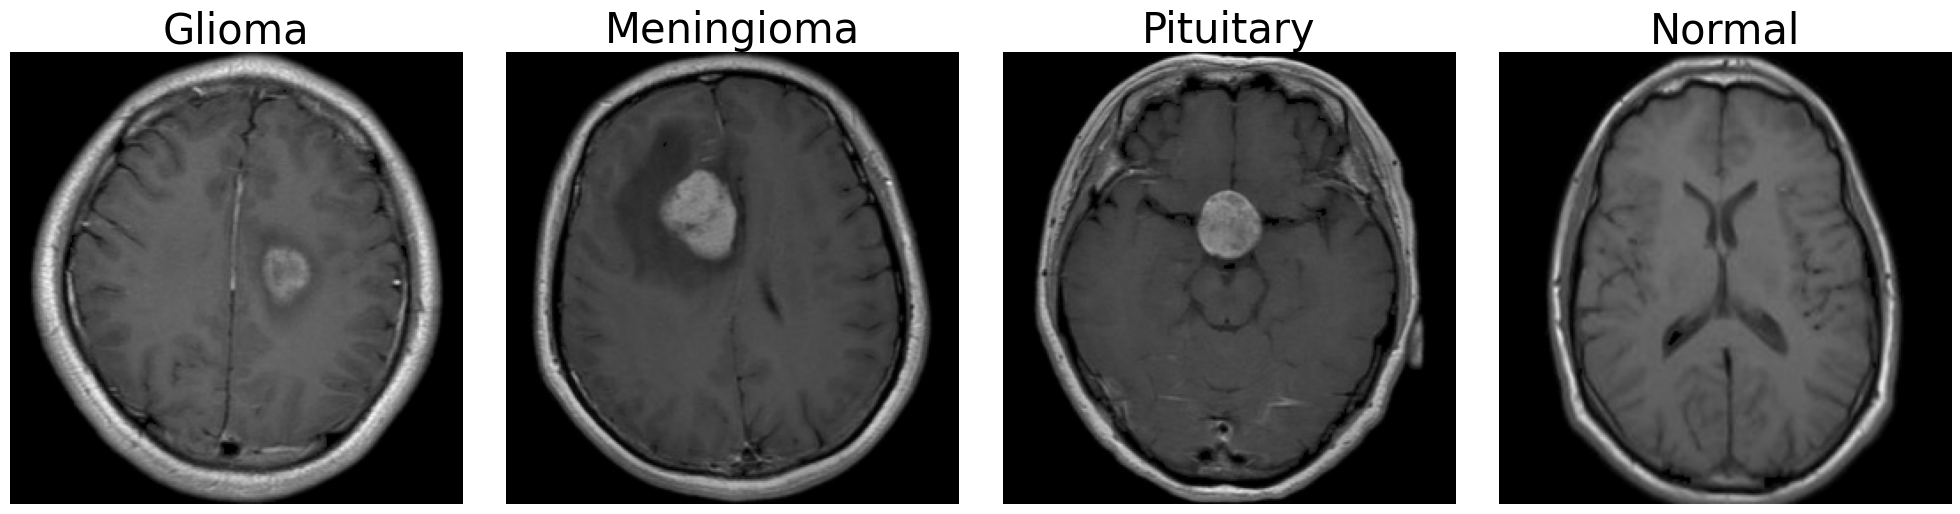

In [8]:
# Carregar as imagens
image_paths = ['./brain-tumor-images/glioma_tumor/G_28.jpg', './brain-tumor-images/meningioma_tumor/M_136.jpg', './brain-tumor-images/pituitary_tumor/P_28.jpg', './brain-tumor-images/normal/N_3.jpg']
class_names = ['Glioma', 'Meningioma', 'Pituitary', 'Normal']

# Criar uma figura
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Adicionar imagens e rótulos à figura
for ax, img_path, class_name in zip(axes, image_paths, class_names):
    image = mpimg.imread(img_path)
    ax.imshow(image)
    ax.set_title(class_name, fontsize=30)
    ax.axis('off')  # Desligar os eixos para a visualização das imagens

# Ajustar espaçamento entre as imagens
plt.tight_layout()

# Salvar ou exibir a figura
plt.savefig('composite_image.png')
plt.show()


### *Data augmentation*

O próximo passo é definir os *transform* que passaremos para as imagens.

As escolhas por trás de cada *transform* escolhido pode ser conferido a seguir:
* **ToImage:** Converter imagem para Tensor.
* **RandomHorizontalFlip e RandomVerticalFlip:** Como as imagens podem ser enviadas rotacionadas, ocasionalmente será aplicada uma rotação horizontal ou vertical com uma probabilidade de 30%.
* **ToDtype:** Para aplicar a normalização é preciso garantir que os valores sejam do tipo *float*.


Temos dois *Compose* com *transforms*, um para treino e um para teste. O segundo não possui possíveis "perturbações" na imagem pois é preciso avaliar os dados originais. Aplica-se apenas aquilo que visa padronizar o formato da imagem para se adequar ao modelo treinado.

In [9]:
transforms_train = v2.Compose([
    v2.ToImage(),
    v2.RandomChoice([
        v2.RandomHorizontalFlip(0.3),
        v2.RandomVerticalFlip(0.3)
    ]),
    v2.ToDtype(torch.float32, scale=True),
])

transforms_test_val = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),

])

### Divisão treino e teste

A próxima etapa é dividir os dados em treino e teste. Para garantir uma divisão determinística, será usado **random_state = 56982** e será pedido para manter a mesma distribuição de classes no conjunto de teste e no conjunto de treino.

Como a escolha dos parâmetros para CNN é um processo bem empírico, vamos dividir a partição de teste também em validação, que será onde definiremos nossos hiperparâmetros.

In [10]:
images_path_train, images_path_test, labels_train, labels_test = train_test_split(images_path, labels, test_size=0.30, random_state=56982, stratify=labels)
images_path_val, images_path_test, labels_val, labels_test = train_test_split(images_path_test, labels_test, test_size=0.6, random_state=56982, stratify=labels_test)

Agora que os argumentos para o construtor *DefaultDataset* está criado, vamos chamá-lo.

In [11]:
train_dataset = DefaultDataset(images_path_train, labels_train, transform=transforms_train)
test_dataset= DefaultDataset(images_path_test, labels_test, transform=transforms_test_val)
val_dataset = DefaultDataset(images_path_val, labels_val, transform=transforms_test_val)

Pequeno teste de sanidade.

Text(0.5, 1.0, 'M_288 | 0')

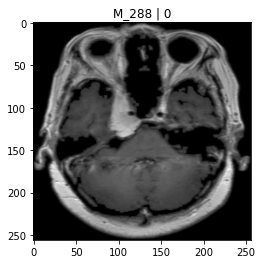

In [ ]:
img, label, idimg = train_dataset[600]
plt.imshow(img.permute(1, 2, 0))
plt.title(f'{idimg} | {labels[label]}')

### DataLoader

Finalmente, cria-se o *DataLoader*.

In [12]:
batch_size = 30
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=batch_size,
                                            shuffle=True)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,
                                            shuffle=True)

val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                            batch_size=batch_size,
                                            shuffle=True)

## Construção do modelo

Muitas coisas relacionadas a machine learning são empíricas e aprendidas conforme se ganha experiência na área. Como não é o nosso caso, decidimos por partirmos de um modelo de três camadas de convolução seguidas de pooling. Conforme formos testanto os hiperparâmetros, podemos ir alterando a estrutura do modelo caso seja necessário, ou seja, modelo obteve uma acurácia baixa em relação ao desejado - que é 90%.

Relembrando, o tamanho original da nossa base é 256 x 256.

### Definição da quantidade de kernels em cada camada

A CNN utilizada até o momento é composta por três camadas de convolução seguidas de pooling. No momento, utilizaremos o tamanho do kernel para cada convolução será 7x7, mas isso será reavaliado posteriormente. Nesse tópico, nosso objetivo é escolhermos a quantidade de kernels por camada.

A quantidade de kernels afeta diretamente a capacidade da rede de aprender características sobre os dados. De modo resumido, cada kernel, que também pode ser chamado de filtro, será especialista em uma dada característica dos nossos dados. Como, por exemplo, bordas e formas. Desse modo, a quantidade de filtros têm um impacto gigantesco sobre a capacidade de aprendizado do modelo. Todavia, se escolhermos muito kernels para nossa rede, corremos o risco de causarmos um overfitting no nosso modelo. Porém , o contrário também é muito prejudicial, poucos filtros podem não ser suficientes para captar todas as nuances das imagens, gerando um modelo ineficiente e com muitas chances de gerar um underfitting.

Dito isso, nosso objetivo será testar diferentes quantidades de kernels em busca daquele que melhor se encaixar com as caracteríscias e tamanho do nosso dataset.

#### Modelo 1 - Kernels de 128, 96 e 64

##### Definição

In [ ]:
class CNN_m1(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN_m1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=7, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 96, kernel_size=7, stride=2, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(96, 64, kernel_size=7, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        # Fazendo a operação de flatten
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
model_m1 = CNN_m1(num_classes=4)

##### Treinamento

O próximo passo é definirmos qual função de perda e qual otimizador iremos utilizar. Adotou-se o learning rating igual a 0.0001 por ser um valor comumente utilizado na área.

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer_m1 = torch.optim.Adam(model_m1.parameters(), lr=0.0001)

In [ ]:
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Movendo o modelo para o device alvo
model_m1.to(device)
loss_sum = 0
epoch_loss = 0
samples = 0

for epoch in range(num_epochs):
    for k, (batch_images, batch_labels, id_img) in enumerate(train_dataloader):

        # Aplicando um flatten na imagem e movendo ela para o device alvo
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        # Fazendo a forward pass
        # observe que o modelo é agnóstico ao batch size
        outputs = model_m1(batch_images)
        loss = loss_func(outputs, batch_labels)

        # Fazendo a otimização
        optimizer_m1.zero_grad()
        loss.backward()
        optimizer_m1.step()

        loss_sum += loss.item() * batch_images.shape[0]
        samples += batch_images.shape[0]
        epoch_loss = float(loss_sum) / float(samples)


    print (f"- Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f}")

- Epoch [1/30] | Loss: 0.9537
- Epoch [2/30] | Loss: 0.8091
- Epoch [3/30] | Loss: 0.7188
- Epoch [4/30] | Loss: 0.6561
- Epoch [5/30] | Loss: 0.6019
- Epoch [6/30] | Loss: 0.5599
- Epoch [7/30] | Loss: 0.5228
- Epoch [8/30] | Loss: 0.4909
- Epoch [9/30] | Loss: 0.4622
- Epoch [10/30] | Loss: 0.4376
- Epoch [11/30] | Loss: 0.4147
- Epoch [12/30] | Loss: 0.3940
- Epoch [13/30] | Loss: 0.3754
- Epoch [14/30] | Loss: 0.3581
- Epoch [15/30] | Loss: 0.3422
- Epoch [16/30] | Loss: 0.3276
- Epoch [17/30] | Loss: 0.3147
- Epoch [18/30] | Loss: 0.3027
- Epoch [19/30] | Loss: 0.2919
- Epoch [20/30] | Loss: 0.2816
- Epoch [21/30] | Loss: 0.2717
- Epoch [22/30] | Loss: 0.2626
- Epoch [23/30] | Loss: 0.2537
- Epoch [24/30] | Loss: 0.2454
- Epoch [25/30] | Loss: 0.2378
- Epoch [26/30] | Loss: 0.2306
- Epoch [27/30] | Loss: 0.2237
- Epoch [28/30] | Loss: 0.2170
- Epoch [29/30] | Loss: 0.2111
- Epoch [30/30] | Loss: 0.2054


##### Inferência

In [ ]:
with torch.no_grad():
    correct, total = 0, 0
    for images, labels, i in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_m1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total}%")

Accuracy: 89.21832884097034%


#### Modelo 2 - Kernels de 128, 64 e 32

##### Definição

In [13]:
class CNN_m4(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN_m4, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=7, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=7, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=7, stride=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        # Fazendo a operação de flatten
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [14]:
model_m2 = CNN_m4(num_classes=4)

##### Treinamento

O próximo passo é definirmos qual função de perda e qual otimizador iremos utilizar. Adotou-se o learning rating igual a 0.0001 por ser um valor comumente utilizado na área.

In [15]:
loss_func = nn.CrossEntropyLoss()
optimizer_m2 = torch.optim.Adam(model_m2.parameters(), lr=0.0001)

In [16]:
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Movendo o modelo para o device alvo
model_m2.to(device)
loss_sum = 0
epoch_loss = 0
samples = 0

for epoch in range(num_epochs):
    for k, (batch_images, batch_labels, id_img) in enumerate(train_dataloader):

        # Aplicando um flatten na imagem e movendo ela para o device alvo
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        # Fazendo a forward pass
        # observe que o modelo é agnóstico ao batch size
        outputs = model_m2(batch_images)
        loss = loss_func(outputs, batch_labels)

        # Fazendo a otimização
        optimizer_m2.zero_grad()
        loss.backward()
        optimizer_m2.step()

        loss_sum += loss.item() * batch_images.shape[0]
        samples += batch_images.shape[0]
        epoch_loss = float(loss_sum) / float(samples)


    print (f"- Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


- Epoch [1/30] | Loss: 1.0573
- Epoch [2/30] | Loss: 0.9144
- Epoch [3/30] | Loss: 0.8254
- Epoch [4/30] | Loss: 0.7551
- Epoch [5/30] | Loss: 0.7033
- Epoch [6/30] | Loss: 0.6579
- Epoch [7/30] | Loss: 0.6186
- Epoch [8/30] | Loss: 0.5845
- Epoch [9/30] | Loss: 0.5557
- Epoch [10/30] | Loss: 0.5284
- Epoch [11/30] | Loss: 0.5035
- Epoch [12/30] | Loss: 0.4815
- Epoch [13/30] | Loss: 0.4616
- Epoch [14/30] | Loss: 0.4436
- Epoch [15/30] | Loss: 0.4258
- Epoch [16/30] | Loss: 0.4099
- Epoch [17/30] | Loss: 0.3948
- Epoch [18/30] | Loss: 0.3807
- Epoch [19/30] | Loss: 0.3674
- Epoch [20/30] | Loss: 0.3551
- Epoch [21/30] | Loss: 0.3441
- Epoch [22/30] | Loss: 0.3335
- Epoch [23/30] | Loss: 0.3233
- Epoch [24/30] | Loss: 0.3136
- Epoch [25/30] | Loss: 0.3042
- Epoch [26/30] | Loss: 0.2960
- Epoch [27/30] | Loss: 0.2878
- Epoch [28/30] | Loss: 0.2801
- Epoch [29/30] | Loss: 0.2730
- Epoch [30/30] | Loss: 0.2658


##### Inferência

In [17]:
with torch.no_grad():
    correct, total = 0, 0
    for images, labels, i in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_m2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total}%")

Accuracy: 84.90566037735849%


#### Modelo 3 - Kernels de 96, 64 e 32

##### Definição

In [ ]:
class CNN_m3(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN_m3, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 64, kernel_size=7, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=7, stride=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        # Fazendo a operação de flatten
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
model_m3 = CNN_m3(num_classes=4)

##### Treinamento

O próximo passo é definirmos qual função de perda e qual otimizador iremos utilizar. Adotou-se o learning rating igual a 0.0001 por ser um valor comumente utilizado na área.

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer_m3 = torch.optim.Adam(model_m3.parameters(), lr=0.0001)

In [ ]:
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Movendo o modelo para o device alvo
model_m3.to(device)
loss_sum = 0
epoch_loss = 0
samples = 0

for epoch in range(num_epochs):
    for k, (batch_images, batch_labels, id_img) in enumerate(train_dataloader):

        # Aplicando um flatten na imagem e movendo ela para o device alvo
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        # Fazendo a forward pass
        # observe que o modelo é agnóstico ao batch size
        outputs = model_m3(batch_images)
        loss = loss_func(outputs, batch_labels)

        # Fazendo a otimização
        optimizer_m3.zero_grad()
        loss.backward()
        optimizer_m3.step()

        loss_sum += loss.item() * batch_images.shape[0]
        samples += batch_images.shape[0]
        epoch_loss = float(loss_sum) / float(samples)


    print (f"- Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f}")

- Epoch [1/30] | Loss: 1.0584
- Epoch [2/30] | Loss: 0.9373
- Epoch [3/30] | Loss: 0.8555
- Epoch [4/30] | Loss: 0.7933
- Epoch [5/30] | Loss: 0.7430
- Epoch [6/30] | Loss: 0.6997
- Epoch [7/30] | Loss: 0.6612
- Epoch [8/30] | Loss: 0.6276
- Epoch [9/30] | Loss: 0.5977
- Epoch [10/30] | Loss: 0.5708
- Epoch [11/30] | Loss: 0.5461
- Epoch [12/30] | Loss: 0.5233
- Epoch [13/30] | Loss: 0.5021
- Epoch [14/30] | Loss: 0.4823
- Epoch [15/30] | Loss: 0.4647
- Epoch [16/30] | Loss: 0.4479
- Epoch [17/30] | Loss: 0.4320
- Epoch [18/30] | Loss: 0.4166
- Epoch [19/30] | Loss: 0.4028
- Epoch [20/30] | Loss: 0.3891
- Epoch [21/30] | Loss: 0.3763
- Epoch [22/30] | Loss: 0.3651
- Epoch [23/30] | Loss: 0.3547
- Epoch [24/30] | Loss: 0.3445
- Epoch [25/30] | Loss: 0.3352
- Epoch [26/30] | Loss: 0.3263
- Epoch [27/30] | Loss: 0.3173
- Epoch [28/30] | Loss: 0.3089
- Epoch [29/30] | Loss: 0.3009
- Epoch [30/30] | Loss: 0.2932


##### Inferência

In [ ]:
with torch.no_grad():
    correct, total = 0, 0
    for images, labels, i in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_m3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total}%")

Accuracy: 88.94878706199461%


#### Modelo 4 - Kernels de 64, 32 e 16

##### Definição

In [ ]:
class CNN_m4(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN_m4, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=0), #111
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #55
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=7, stride=2, padding=0), #27
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #7
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=7, stride=2, padding=0), #3
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # 1
        self.fc = nn.Linear(64, num_classes) # 1 * 16 * 16

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        # Fazendo a operação de flatten
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
model_m4 = CNN_m4(num_classes=4)

##### Treinamento

O próximo passo é definirmos qual função de perda e qual otimizador iremos utilizar. Adotou-se o learning rating igual a 0.0001 por ser um valor comumente utilizado na área.

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer_m4 = torch.optim.Adam(model_m4.parameters(), lr=0.0001)

In [ ]:
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Movendo o modelo para o device alvo
model_m4.to(device)
loss_sum = 0
epoch_loss = 0
samples = 0

for epoch in range(num_epochs):
    for k, (batch_images, batch_labels, id_img) in enumerate(train_dataloader):

        # Aplicando um flatten na imagem e movendo ela para o device alvo
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        # Fazendo a forward pass
        # observe que o modelo é agnóstico ao batch size
        outputs = model_m4(batch_images)
        loss = loss_func(outputs, batch_labels)

        # Fazendo a otimização
        optimizer_m4.zero_grad()
        loss.backward()
        optimizer_m4.step()

        loss_sum += loss.item() * batch_images.shape[0]
        samples += batch_images.shape[0]
        epoch_loss = float(loss_sum) / float(samples)


    print (f"- Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f}")

- Epoch [1/30] | Loss: 1.1471
- Epoch [2/30] | Loss: 1.0427
- Epoch [3/30] | Loss: 0.9781
- Epoch [4/30] | Loss: 0.9253
- Epoch [5/30] | Loss: 0.8824
- Epoch [6/30] | Loss: 0.8438
- Epoch [7/30] | Loss: 0.8114
- Epoch [8/30] | Loss: 0.7824
- Epoch [9/30] | Loss: 0.7529
- Epoch [10/30] | Loss: 0.7279
- Epoch [11/30] | Loss: 0.7035
- Epoch [12/30] | Loss: 0.6806
- Epoch [13/30] | Loss: 0.6606
- Epoch [14/30] | Loss: 0.6403
- Epoch [15/30] | Loss: 0.6223
- Epoch [16/30] | Loss: 0.6054
- Epoch [17/30] | Loss: 0.5898
- Epoch [18/30] | Loss: 0.5744
- Epoch [19/30] | Loss: 0.5596
- Epoch [20/30] | Loss: 0.5458
- Epoch [21/30] | Loss: 0.5326
- Epoch [22/30] | Loss: 0.5196
- Epoch [23/30] | Loss: 0.5069
- Epoch [24/30] | Loss: 0.4955
- Epoch [25/30] | Loss: 0.4846
- Epoch [26/30] | Loss: 0.4739
- Epoch [27/30] | Loss: 0.4631
- Epoch [28/30] | Loss: 0.4532
- Epoch [29/30] | Loss: 0.4435
- Epoch [30/30] | Loss: 0.4344


##### Inferência

In [ ]:
with torch.no_grad():
    correct, total = 0, 0
    for images, labels, i in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_m4(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total}%")

Accuracy: 85.44474393530997%


#### Resultado quantidade de kernels

A partir da acurácia dos modelos 1, 2, 3 e 4 observou-se que o modelo com melhor resultado foi o **modelo 1 com 128, 96 e 64 features por camada**, respectivamente.

### Definição do tamanho do kernel

A próxima etapa para a definição da CNN que vamos utilizar é decidir o tamanho do kernel. Para isso, vamos testar dois tamanhos diferentes, **5x5** e **7x7**, sendo que o modelo 1, anteriormente testado, já serve de comparação como modelo 7x7. De modo geral, a definição dos parâmetros de uma CNN é algo muito empírico. Todavia, existem indícios de quais parâmetros são recomendados para certas situações. Como os tumores cerebrais costumam ter um tamanho considerável em relação a imagem, a escolha de kernels de tamanhos pequenos poderiam deixar passar informações relevantes para a indentificação do tumor. Assim, o tamanho 3x3 foi descartado. Do mesmo modo, um kernel 11x11 pode ser grande demais para perceber as informações relevantes, mas ainda assim valeria o teste, caso não fosse a maior complexidade computacional envolvida (levaria mais tempo do que temos infelizmente). Desse modo, escolhemos os tamanhos 5x5 e 7x7 para testarmos.

#### Modelo 5 - 3 camadas com kernel 5x5

##### Definição

In [ ]:
class CNN_m5(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN_m5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=5, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 96, kernel_size=5, stride=2, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(96, 64, kernel_size=5, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(576, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        # Fazendo a operação de flatten
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
model_m5 = CNN_m5(num_classes=4)

##### Treinamento

O próximo passo é definirmos qual função de perda e qual otimizador iremos utilizar. Adotou-se o learning rating igual a 0.0001 por ser um valor comumente utilizado na área.

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer_m5 = torch.optim.Adam(model_m5.parameters(), lr=0.0001)

In [ ]:
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Movendo o modelo para o device alvo
model_m5.to(device)
loss_sum = 0
epoch_loss = 0
samples = 0

for epoch in range(num_epochs):
    for k, (batch_images, batch_labels, id_img) in enumerate(train_dataloader):

        # Aplicando um flatten na imagem e movendo ela para o device alvo
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        # Fazendo a forward pass
        # observe que o modelo é agnóstico ao batch size
        outputs = model_m5(batch_images)
        loss = loss_func(outputs, batch_labels)

        # Fazendo a otimização
        optimizer_m5.zero_grad()
        loss.backward()
        optimizer_m5.step()

        loss_sum += loss.item() * batch_images.shape[0]
        samples += batch_images.shape[0]
        epoch_loss = float(loss_sum) / float(samples)


    print (f"- Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f}")

- Epoch [1/30] | Loss: 1.0189
- Epoch [2/30] | Loss: 0.8930
- Epoch [3/30] | Loss: 0.8065
- Epoch [4/30] | Loss: 0.7442
- Epoch [5/30] | Loss: 0.6947
- Epoch [6/30] | Loss: 0.6507
- Epoch [7/30] | Loss: 0.6141
- Epoch [8/30] | Loss: 0.5835
- Epoch [9/30] | Loss: 0.5547
- Epoch [10/30] | Loss: 0.5273
- Epoch [11/30] | Loss: 0.5028
- Epoch [12/30] | Loss: 0.4809
- Epoch [13/30] | Loss: 0.4610
- Epoch [14/30] | Loss: 0.4429
- Epoch [15/30] | Loss: 0.4267
- Epoch [16/30] | Loss: 0.4112
- Epoch [17/30] | Loss: 0.3959
- Epoch [18/30] | Loss: 0.3818
- Epoch [19/30] | Loss: 0.3689
- Epoch [20/30] | Loss: 0.3574
- Epoch [21/30] | Loss: 0.3465
- Epoch [22/30] | Loss: 0.3359
- Epoch [23/30] | Loss: 0.3265
- Epoch [24/30] | Loss: 0.3172
- Epoch [25/30] | Loss: 0.3087
- Epoch [26/30] | Loss: 0.3000
- Epoch [27/30] | Loss: 0.2918
- Epoch [28/30] | Loss: 0.2841
- Epoch [29/30] | Loss: 0.2772
- Epoch [30/30] | Loss: 0.2702


##### Inferência

In [ ]:
with torch.no_grad():
    correct, total = 0, 0
    for images, labels, i in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_m5(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total}%")

Accuracy: 88.67924528301887%


#### Resultado definição do kernel

Com base na acurácia obtida através da avaliação dos kernels 5x5 e 7x7, optou-se pelo **kernel de 7x7**.

Ademais, os dois modelos foram testados com 20, 30 e 40 épocas. Percebeu-se uma melhora na acurácia dos resultados ao aumentar de 20 para 30, mas o mesmo não foi observado com uma maior quantidade de épocas. Assim, usaremos como padrão para testar nossos modelos **30 épocas para treinamento**.

### Aplicação do Dropout

O **Dropout** é uma técnica aplicada para evitar overfitting e para "apurar" o aprendizado do modelo. O processo consiste em cada etapa do treinamento desativar aleatoriamente um percentual de neurônios, não transmitindo eles para  o forward pass e nem para o backpropagation. Modelos como a Resnet50 usam o Dropout antes da sua camada final, que é a rede neural *fully connected*.

Vamos testar se essa técnica influencia positivamente no nosso modelo. O percentual de Dropout que vamos utilizar é de 30%, assim como na Resnet50.

#### Modelo 6 - Aplicação do Dropout

##### Definição

In [23]:
class CNN_m6(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN_m6, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=7, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 96, kernel_size=7, stride=2, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(96, 64, kernel_size=7, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(256, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        # Fazendo a operação de flatten
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [24]:
model_m6 = CNN_m6(num_classes=4)

##### Treinamento

O próximo passo é definirmos qual função de perda e qual otimizador iremos utilizar. Adotou-se o learning rating igual a 0.0001 por ser um valor comumente utilizado na área.

In [25]:
loss_func = nn.CrossEntropyLoss()
optimizer_m6 = torch.optim.Adam(model_m6.parameters(), lr=0.0001)

In [26]:
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Movendo o modelo para o device alvo
model_m6.to(device)
loss_sum = 0
epoch_loss = 0
samples = 0

for epoch in range(num_epochs):
    for k, (batch_images, batch_labels, id_img) in enumerate(train_dataloader):

        # Aplicando um flatten na imagem e movendo ela para o device alvo
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        # Fazendo a forward pass
        # observe que o modelo é agnóstico ao batch size
        outputs = model_m6(batch_images)
        loss = loss_func(outputs, batch_labels)

        # Fazendo a otimização
        optimizer_m6.zero_grad()
        loss.backward()
        optimizer_m6.step()

        loss_sum += loss.item() * batch_images.shape[0]
        samples += batch_images.shape[0]
        epoch_loss = float(loss_sum) / float(samples)


    print (f"- Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f}")

- Epoch [1/30] | Loss: 1.0109
- Epoch [2/30] | Loss: 0.8855
- Epoch [3/30] | Loss: 0.7984
- Epoch [4/30] | Loss: 0.7407
- Epoch [5/30] | Loss: 0.6898
- Epoch [6/30] | Loss: 0.6489
- Epoch [7/30] | Loss: 0.6125
- Epoch [8/30] | Loss: 0.5804
- Epoch [9/30] | Loss: 0.5517
- Epoch [10/30] | Loss: 0.5269
- Epoch [11/30] | Loss: 0.5043
- Epoch [12/30] | Loss: 0.4831
- Epoch [13/30] | Loss: 0.4635
- Epoch [14/30] | Loss: 0.4448
- Epoch [15/30] | Loss: 0.4293
- Epoch [16/30] | Loss: 0.4148
- Epoch [17/30] | Loss: 0.4010
- Epoch [18/30] | Loss: 0.3885
- Epoch [19/30] | Loss: 0.3762
- Epoch [20/30] | Loss: 0.3641
- Epoch [21/30] | Loss: 0.3530
- Epoch [22/30] | Loss: 0.3427
- Epoch [23/30] | Loss: 0.3333
- Epoch [24/30] | Loss: 0.3249
- Epoch [25/30] | Loss: 0.3163
- Epoch [26/30] | Loss: 0.3085
- Epoch [27/30] | Loss: 0.3005
- Epoch [28/30] | Loss: 0.2934
- Epoch [29/30] | Loss: 0.2865
- Epoch [30/30] | Loss: 0.2797


##### Inferência

In [27]:
with torch.no_grad():
    correct, total = 0, 0
    for images, labels, i in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_m6(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total}%")

Accuracy: 85.98382749326146%


#### Resultado Dropout

Apesar de ser uma técnica muita eficiente, o Dropout não teve um impacto significante na acurácia do nosso modelo. Provavelmente isso se deve ao fato de não estarmos desenvolvendo um modelo muito complexo, com muitas camadas. Desse modo, optamos por não adicionar o Dropout no nosso modelo.

## Treinamento e Teste do modelo oficial

Os modelos treinados até o momento tinham como intuito definir os melhores parâmetros para o modelo oficial. Desse modo, para ser mais rápido o processo, não executamos a etapa de validação. Todavia, agora que chegamos a etapa final, essa parte se torna insdispensável, pois é fundamental para definirmos por quantas épocas podemos treinar o nosso modelo.

### Modelo

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=7, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 96, kernel_size=7, stride=2, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(96, 64, kernel_size=7, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        # Fazendo a operação de flatten
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
model = CNN(num_classes=4)

### Treinamento

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
def eval_loss(data_loader):
    with torch.no_grad():
        loss, cnt = 0, 0
        for images, labels, img_id in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss += loss_func(outputs, labels).item()
            cnt += 1
    return loss/cnt

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
num_epochs = 35
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Movendo o modelo para o device alvo
model.to(device)

best_loss = np.inf

for epoch in range(num_epochs):

    loss_epoch, cnt = 0, 0
    for k, (batch_images, batch_labels, id_img) in enumerate(train_dataloader):

        # Aplicando um flatten na imagem e movendo ela para o device alvo
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        # Fazendo a forward pass
        # observe que o modelo é agnóstico ao batch size
        outputs = model(batch_images)
        loss = loss_func(outputs, batch_labels)
        loss_epoch += loss.item()

        # Fazendo a otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cnt += 1


    loss_epoch = loss_epoch / cnt
    loss_val_epoch = eval_loss(val_dataloader)


    writer.add_scalar("LossTrain", loss_epoch, epoch)
    writer.add_scalar("LossVal", loss_val_epoch, epoch)

    temp = {
        "Train": loss_epoch,
        "Val": loss_val_epoch
    }
    writer.add_scalars("Loss", temp, epoch)


    # Salvando o checkpoint da última época
    checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_func,
            'loss_val': loss_epoch
    }
    torch.save(checkpoint, "last_checkpoint.pth")


    # Salvando a mellhor execução
    if loss < best_loss:
        best_loss = loss
        torch.save(checkpoint, "best_checkpoint.pth")

    print (f"- Epoch [{epoch+1}/{num_epochs}] | Loss: {loss_epoch:.4f} | Loss Val: {loss_val_epoch:.4f}")

- Epoch [1/35] | Loss: 0.9680 | Loss Val: 0.7730
- Epoch [2/35] | Loss: 0.6887 | Loss Val: 0.6316
- Epoch [3/35] | Loss: 0.5565 | Loss Val: 0.5152
- Epoch [4/35] | Loss: 0.4745 | Loss Val: 0.5025
- Epoch [5/35] | Loss: 0.3967 | Loss Val: 0.4623
- Epoch [6/35] | Loss: 0.3522 | Loss Val: 0.4112
- Epoch [7/35] | Loss: 0.3005 | Loss Val: 0.4118
- Epoch [8/35] | Loss: 0.2712 | Loss Val: 0.3554
- Epoch [9/35] | Loss: 0.2297 | Loss Val: 0.3390
- Epoch [10/35] | Loss: 0.1990 | Loss Val: 0.3573
- Epoch [11/35] | Loss: 0.1836 | Loss Val: 0.3201
- Epoch [12/35] | Loss: 0.1628 | Loss Val: 0.3673
- Epoch [13/35] | Loss: 0.1784 | Loss Val: 0.3202
- Epoch [14/35] | Loss: 0.1425 | Loss Val: 0.3060
- Epoch [15/35] | Loss: 0.1400 | Loss Val: 0.3083
- Epoch [16/35] | Loss: 0.1082 | Loss Val: 0.3065
- Epoch [17/35] | Loss: 0.1005 | Loss Val: 0.3519
- Epoch [18/35] | Loss: 0.1048 | Loss Val: 0.2790
- Epoch [19/35] | Loss: 0.0978 | Loss Val: 0.3106
- Epoch [20/35] | Loss: 0.0841 | Loss Val: 0.2902
- Epoch [

### Teste

In [ ]:
eval_loss(test_dataloader)

0.2714630435956152

In [ ]:
with torch.no_grad():
    correct, total = 0, 0
    y_test = []
    pred_test = []
    probs = []
    for images, labels, img_id in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        prob = torch.softmax(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_test.extend([ torch.Tensor.cpu(x).item() for x in labels])
        pred_test.extend([ torch.Tensor.cpu(x).item() for x in predicted])
        probs.extend(prob)

    print(f"Accuracy: {100 * correct / total}%")

Accuracy: 90.50179211469533%


In [ ]:
probs_sep = [[], [], [], []]
for tensor in probs:
    for i in range(len(tensor)):
        probs_sep[i].extend([tensor[i].item()])



**Matriz de confusão**

(array([0, 1, 2, 3]),
 [Text(0, 0, 'glioma_tumor'),
  Text(0, 1, 'meningioma_tumor'),
  Text(0, 2, 'normal'),
  Text(0, 3, 'pituitary_tumor')])

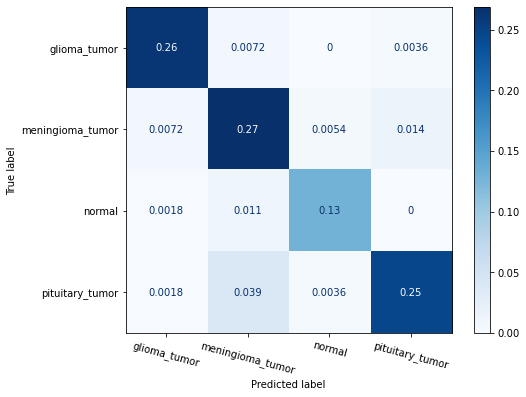

In [ ]:
labels_name = ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']
cm = confusion_matrix(y_test, pred_test)
cm = cm.astype('float') / len(y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_name)
# disp.plot()
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues")

# Inclinando os rótulos do eixo x
plt.xticks(rotation=-15)
plt.yticks(rotation=0)


(array([0, 1, 2, 3]),
 [Text(0, 0, 'glioma_tumor'),
  Text(0, 1, 'meningioma_tumor'),
  Text(0, 2, 'normal'),
  Text(0, 3, 'pituitary_tumor')])

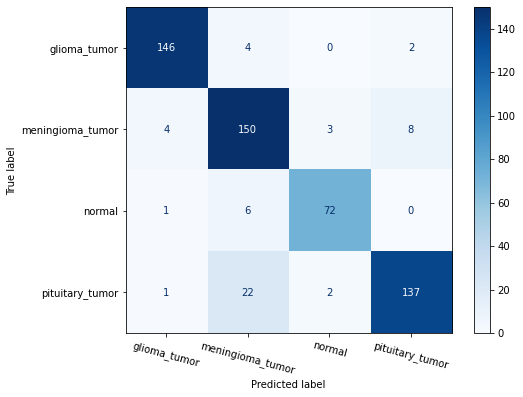

In [ ]:
labels_name = ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']
cm = confusion_matrix(y_test, pred_test)
# cm = cm.astype('float') / len(y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_name)
# disp.plot()
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues")

# Inclinando os rótulos do eixo x
plt.xticks(rotation=-15)
plt.yticks(rotation=0)

**Curva ROC**

In [ ]:
from sklearn.preprocessing import label_binarize

# Binarizando as etiquetas
labels_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculando a curva ROC e AUC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_sep[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

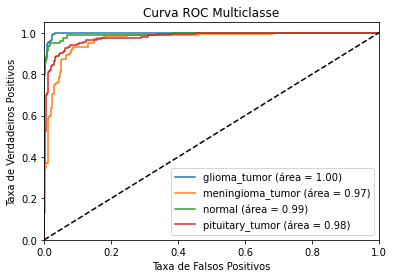

In [ ]:
# Plotando a curva ROC para cada classe
plt.figure()
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'{labels_name[i]} (área = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC Multiclasse')
plt.legend(loc="lower right")
plt.show()

## Resultado Modelo

Um tumor cerebral é uma condição séria que requer uma avaliação imediata para que seja possível montar um plano de tratamento. Todavia, antes de que o tratamento ou até mesmo uma cirúrgia para removê-lo seja feita, é preciso diagnosticar corretamente o tipo de tumor. Esse diagnóstico ocorre principalmente por meio da avaliação de *varreduras cerebrais* e do estudo de imagens de ressonância magnética. Devido a localização dos tumores, nem sempre a realização de biópsias é possível. Isso demonstra a importância de uma inteligência artificial como forma de auxílio aos profissionais responsáveis por avaliar tais exames. Um diagnóstico preciso é crucial para a vida do paciente, porque o tipo de tumor irá determinar o tipo de tratamento necessário.

Nosso modelo obteve cerca de 90% de acurácia. Um resultado bem otimista considerando que não foram utilizados nenhum modelo pré-treinado como base. Além disso, conseguimos com alta precisão diferenciar um cérebro saudável de um cérebro com a presença de algum tumor. A matriz de confusão e a curva ROC podem ser verificadas como comprovação. Uma outra vitória do nosso modelo é com alta precisão conseguir diferenciar os três tipos de tumores, além de cérebros normais. Essa capacidade de distinção pode ser explorada para auxílio da distinção entre os diferentes tipos de tumor. A matriz de confusão mostra que o nosso modelo confunde com maior frequência as classes pituitary e meningioma, e se formos verificar a imagem com uma imagem de cada classe, podemos perceber que visualmente eles são os tipos que mais se assemelham, o que justifica essa dificuldade do nosso modelo.

Por último, ressalta-se que existem diversos tipos de tumores cerebrais, mas os dois mais comuns, meningioma e pituitary, estão presentes no nosso modelo. Mais tumores não foram investigados devido a limitação de datasets públicos.